## PPO Agent Training with Action Masking

Here we will import the Proximal Policy Optimization (PPO) algorithm from Ray.RLlib and train it with minimal parameters.

Action masking allows the policy to start learning the best strategy from the get-go, without having to first learn the rules of the game.
Enforcing action masking in Ray requires the definition of a custom model, which post-processes the logits coming out of the actual model (here, a Fully Connceted Neural Network) setting to -inf those of forbidden actions

In [1]:
from wildcatter.advanced_environment_for_RLib import AdvancedDriller
import ray
from ray import air, tune
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.tf.fcnet import FullyConnectedNetwork
from ray.rllib.utils.framework import try_import_tf
from ray.rllib.models import ModelCatalog
from gym.spaces import Box, Dict
import numpy as np
import matplotlib.pyplot as plt
from time import time

tf1, tf, tfv = try_import_tf(error=True)

class WildcatterActionMaskedModel(TFModelV2):
     
    def __init__(self, 
                 obs_space,
                 action_space,
                 num_outputs,
                 model_config,
                 name,
                 true_obs_shape=(11,40),
                 action_embed_size=4+38+1,
                 *args, **kwargs):
         
        super(WildcatterActionMaskedModel, self).__init__(obs_space,
            action_space, num_outputs, model_config, name, 
            *args, **kwargs)
         
        self.action_embed_model = FullyConnectedNetwork(
            Box(-10, 10, shape=true_obs_shape), 
                action_space, action_embed_size,
            model_config, name + "_action_embed")
        #self.register_variables(self.action_embed_model.variables())
 
    def forward(self, input_dict, state, seq_lens):
        # Extract the available actions tensor from the observation.
        avail_actions = input_dict["obs"]["avail_actions"]
        action_mask = input_dict["obs"]["action_mask"]
        # Compute the predicted action embedding
        action_embed, _ = self.action_embed_model({
            "obs": input_dict["obs"]["state"]})
        # Expand the model output
        #intent_vector = tf.expand_dims(action_embed, 1)
        # Batch dot product
        #action_logits = tf.reduce_sum(avail_actions * intent_vector,
        #    axis=2)
        # Mask out invalid actions (use tf.float32.min for stability)
        inf_mask = tf.maximum(tf.math.log(action_mask), tf.float32.min)
        #return action_logits + inf_mask, state
        return action_embed + inf_mask, state
 
    def value_function(self):
        return self.action_embed_model.value_function()
    
ModelCatalog.register_custom_model('wildcatter_masked', WildcatterActionMaskedModel)

## Setting environment config dictionary

Here we list the config dictionaries for various environment types, selecting the one we want to train for.

In [2]:
env_random_config = dict(model_type = "random",
                  nrow=11,
                  ncol=40,
                  available_pipe=30,
                  available_wells=2,
                  oil_price = 40,
                  relocation_cost = 0.2,
                  drilling_cost = 0.5,
                  drilling_depth_markup = 0.1,
#                  seed = 0,
                 )

env_random_pockets_config = dict(model_type = "random_pockets",
                  nrow=11,
                  ncol=40,
                  available_pipe=30,
                  available_wells=3,
                  oil_price = 1,
                  relocation_cost = 0.2,
                  drilling_cost = 0.5,
                  drilling_depth_markup = 0.1,
#                  seed = 0,
                 )

env_2d_two_rectangular_targets_config = dict(model_type = "from_csv",
                  model_path=r"/home/studio-lab-user/sagemaker-studiolab-notebooks/wildcatter-ThreeAmigos/examples/data/2d_two_rectangular_targets.csv",
                  delim=",",
                  available_pipe=30,
                  available_wells=2,
                  oil_price = 40,
                  relocation_cost = 0.2,
                  drilling_cost = 0.5,
                  drilling_depth_markup = 0.1,
#                  seed = 0,
                  )

env_config = env_random_pockets_config

## Loading the PPO trainer

Let's instantiate a PPO trainer with three workers (to exploit the 4 CPUs available on SageMaker Studio Lab)

In [3]:
import ray.rllib.algorithms.ppo as ppo
from ray.tune.logger import pretty_print
ray.init(ignore_reinit_error=True)
config = ppo.DEFAULT_CONFIG.copy()
special_config = {"num_gpus" : 0,
                  "num_workers" : 3, # Parallel training!
                  "env": AdvancedDriller,
                  "env_config": env_config,
                  "model": {
                      "custom_model": "wildcatter_masked",
                  },
                  "horizon" : 40
                 }
config.update(special_config)
trainer = ppo.PPO(config=config)
# In case we want to restore a checkpointed trainer
#trainer.restore(my_checkpoint)

2022-08-27 13:10:46,066	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 4294967296 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.62gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-08-27 13:10:47,113	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2022-08-27 13:10:48,380	INFO algorithm.py:1871 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-08-27 13:10:48,381	WARNING ppo.py:350 -- `train_batch_size` (4000) cannot be achieved wit

In [4]:
# Check that action masking works
env = trainer.env_creator(env_config)
obs = env.reset()
obs['action_mask'][:-1] = 0 # Having set to zero the action mask of all other actions, the only remaining valid action is number 42
# Let's ask the model to select an action for 10k times
actions = np.array([trainer.compute_single_action(obs) for i in range(10000)])
# Check that the action being selected has always been 42
all(actions==42)

True

In [5]:
# Let's do 100 training epochs
for i in range(100):
    result = trainer.train()
    if i%10 == 0:
        checkpoint = trainer.save("my_checkpoint")
        print(f"Epoch: {i}; episode_reward_mean: {result.get('episode_reward_mean')}")

checkpoint = trainer.save("my_checkpoint")
print("Final checkpoint saved")
print(pretty_print(result))

(RolloutWorker pid=23710) /home/studio-lab-user/.conda/envs/wildcatter-ThreeAmigos/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
(RolloutWorker pid=23710)   ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Epoch: 0; episode_reward_mean: -0.9345108695652172
Epoch: 10; episode_reward_mean: 6.506851851851851
Epoch: 20; episode_reward_mean: 20.56469194312796
Epoch: 30; episode_reward_mean: 24.763260340632606
Epoch: 40; episode_reward_mean: 28.33341523341523
Epoch: 50; episode_reward_mean: 32.671164021164024
Epoch: 60; episode_reward_mean: 35.22183288409703
Epoch: 70; episode_reward_mean: 39.790449438202245
Epoch: 80; episode_reward_mean: 44.36424581005586
Epoch: 90; episode_reward_mean: 44.20028818443804
Final checkpoint saved
agent_timesteps_total: 400200
counters:
  num_agent_steps_sampled: 400200
  num_agent_steps_trained: 400200
  num_env_steps_sampled: 400200
  num_env_steps_trained: 400200
custom_metrics: {}
date: 2022-08-27_13-22-56
done: false
episode_len_mean: 11.831360946745562
episode_media: {}
episode_reward_max: 86.7
episode_reward_mean: 45.523668639053255
episode_reward_min: -25.00000000000001
episodes_this_iter: 338
episodes_total: 40630
experiment_id: d7767b281093477b9c8cd9e0

In [6]:
# Check policy
eval_config = ppo.DEFAULT_CONFIG.copy()
special_config = {"num_workers" : 0,
                  "env": AdvancedDriller,
                  "env_config": env_config,
                  "model": {
                      "custom_model": "wildcatter_masked",
                  },
                  "horizon" : 40,
                  "explore" : False, # Always returns best action
                 }
eval_config.update(special_config)
agent = ppo.PPO(config=eval_config, env=AdvancedDriller)

2022-08-27 13:24:30,101	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-08-27 13:24:31,487	WARNING util.py:65 -- Install gputil for GPU system monitoring.


In [ ]:
# Here we restore an agent we trained for 100 epochs with the standard parameters
agent.restore(r"/home/studio-lab-user/sagemaker-studiolab-notebooks/wildcatter-ThreeAmigos/examples/my_checkpoint/checkpoint_000100/")

Beginning Drill Campaign
Action: 14; reward: -0.0; total score: 0.0
Action: 0; reward: -0.6; total score: -0.6
Action: 0; reward: -0.7; total score: -1.2999999999999998
Action: 0; reward: -0.8; total score: -2.0999999999999996
Action: 42; reward: 0; total score: -2.0999999999999996
Action: 31; reward: -0.0; total score: -2.0999999999999996
Action: 0; reward: -0.6; total score: -2.6999999999999997
Action: 0; reward: -0.7; total score: -3.3999999999999995
Action: 0; reward: -0.8; total score: -4.199999999999999
Action: 0; reward: -0.9; total score: -5.1
Action: 42; reward: 30; total score: 24.9
Action: 42; reward: 1200; total score: 1224.9


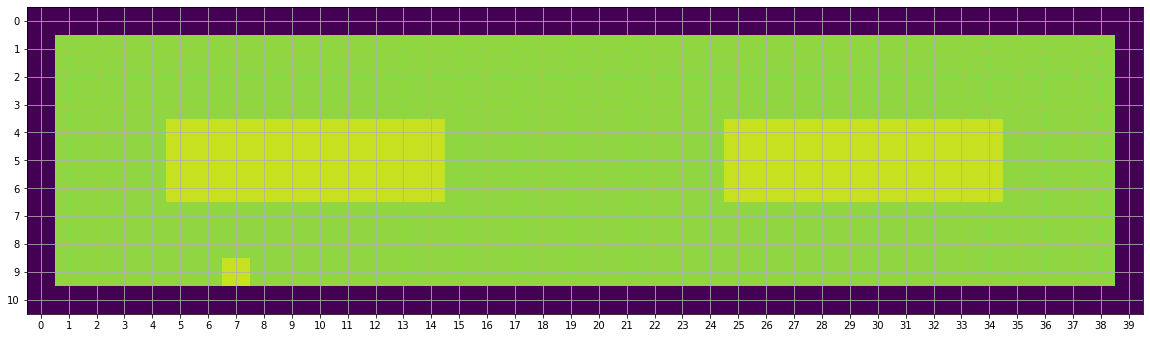

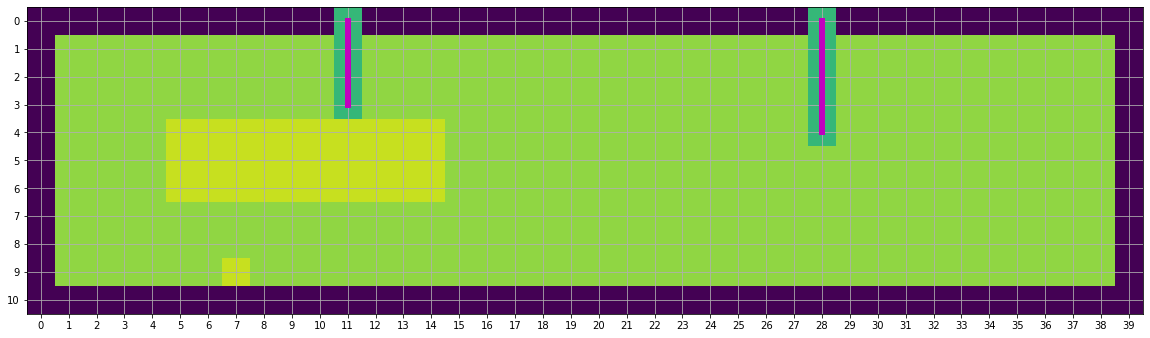

In [27]:
#env_config = env_random_pockets_config
env_config = env_2d_two_rectangular_targets_config
env = AdvancedDriller(env_config)
print("Beginning Drill Campaign")
obs = env.reset()
env.state[9,7]=1
done = False
score = 0
plt.figure(figsize=(20, 20))
plt.imshow(env.state, vmin=-10, vmax=2)
plt.xticks(np.arange(0, env.ncol, 1.0))
plt.yticks(np.arange(0, env.nrow, 1.0))
plt.xlim([-0.5, env.ncol - 0.5])
plt.ylim([env.nrow - 0.5, -0.5])
plt.grid()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    score += reward
    print(f"Action: {action}; reward: {reward}; total score: {score}")

plt.figure(figsize=(20, 20))
plt.imshow(env.state, vmin=-10, vmax=2)
for well in env.trajectory:
    traj_z, traj_x = np.asarray(well).T
    plt.plot(traj_x, traj_z, "-", c="m", linewidth=6)
plt.xticks(np.arange(0, env.ncol, 1.0))
plt.yticks(np.arange(0, env.nrow, 1.0))
plt.xlim([-0.5, env.ncol - 0.5])
plt.ylim([env.nrow - 0.5, -0.5])
plt.grid()
